<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [104]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use('ggplot')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovateable:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [105]:
# Load the data
house = pd.read_csv('./housing.csv')

In [106]:
house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [107]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [108]:
# this is quite big and we only want residential properties
# so let's create a df of just residential properties by subsetting the original df

residential = ['RH', 'RL', 'RP', 'RM', 'FV']


residents = house[house.MSZoning.isin(residential)]
residents.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [109]:
residents.shape

(1450, 81)

In [110]:
residents.MSZoning.unique()

array(['RL', 'RM', 'FV', 'RH'], dtype=object)

In [111]:
house.MSZoning.unique()

array(['RL', 'RM', 'C (all)', 'FV', 'RH'], dtype=object)

In [112]:
residents.isnull().sum().sort_values(ascending = False).nlargest(20)

PoolQC          1443
MiscFeature     1398
Alley           1361
Fence           1172
FireplaceQu      681
LotFrontage      259
GarageYrBlt       79
GarageCond        79
GarageType        79
GarageFinish      79
GarageQual        79
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
MasVnrType         8
Electrical         1
Id                 0
dtype: int64

In [113]:
#no electricity?  Is that reliable data? Even if it is, we probably don't want to base our model on it
residents.dropna(subset = ['Electrical'])


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [114]:
#lets look at the missing data from lot frontage
residents[residents.LotFrontage.isnull()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
12,13,20,RL,NaN,12968,Pave,NaN,IR2,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,144000
14,15,20,RL,NaN,10920,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,GdWo,NaN,0,5,2008,WD,Normal,157000
16,17,20,RL,NaN,11241,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,700,3,2010,WD,Normal,149000
24,25,20,RL,NaN,8246,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,5,2010,WD,Normal,154000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1429,1430,20,RL,NaN,12546,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2007,WD,Normal,182900
1431,1432,120,RL,NaN,4928,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,10,2009,WD,Normal,143750
1441,1442,120,RM,NaN,4426,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2008,WD,Normal,149300
1443,1444,30,RL,NaN,8854,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2009,WD,Normal,121000


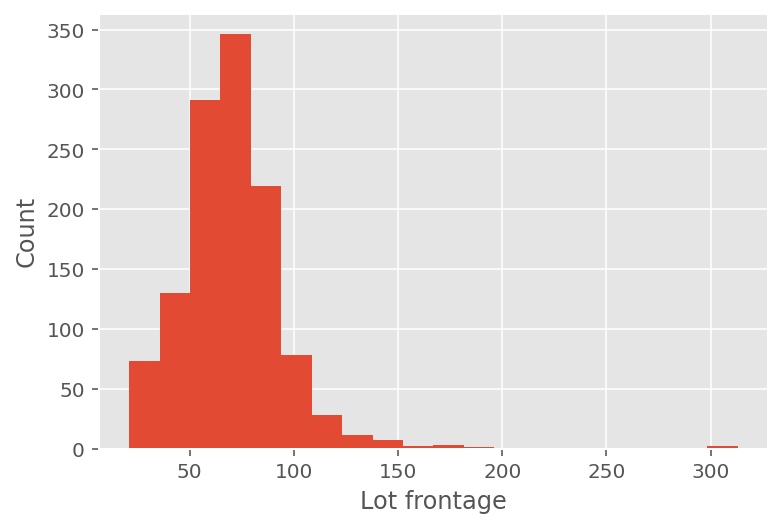

In [115]:
plt.hist(residents.LotFrontage, bins = 20)
plt.xlabel('Lot frontage')
plt.ylabel('Count');

In [116]:
# there doesn't seem to be any reason why (eg, no lot) no value for lotfrontage 
# and all other lots seem to have a value greater than 0

In [117]:
residents.LotFrontage.fillna(residents.LotFrontage.median(), inplace = True)

/var/folders/bm/2w01_g15327_2drgpr6m5jrm0000gn/T/ipykernel_61256/3840033595.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  residents.LotFrontage.fillna(residents.LotFrontage.median(), inplace = True)


In [118]:
residents.LotFrontage.unique()

array([ 65.,  80.,  68.,  60.,  84.,  85.,  75.,  70.,  51.,  50.,  91.,
        72.,  66., 101.,  57.,  44., 110.,  98.,  47., 108., 112.,  74.,
       115.,  61.,  48.,  33.,  52., 100.,  24.,  89.,  63.,  76.,  81.,
        95.,  69.,  21.,  32.,  78., 121., 122.,  40.,  73.,  77.,  64.,
        94., 105.,  34.,  90.,  55.,  88.,  82.,  71., 120., 107.,  92.,
       134.,  62.,  86., 141.,  97.,  54.,  41.,  79., 174.,  99.,  67.,
        83.,  43., 103.,  93.,  30., 129., 140.,  35.,  37., 118.,  87.,
       116., 150., 111.,  49.,  96.,  59.,  36.,  56., 102.,  58.,  38.,
       109., 130.,  53., 137.,  45., 106., 104.,  42.,  39., 144., 114.,
       128., 149., 313., 168., 182., 138., 160., 152., 124., 153.,  46.])

In [119]:
#any other continuous variables with missing values?

residents.select_dtypes(['float', 'int']).isna().sum().nlargest(5)

GarageYrBlt    79
MasVnrArea      8
Id              0
MSSubClass      0
LotFrontage     0
dtype: int64

In [120]:
residents.GarageYrBlt.unique()

array([2003., 1976., 2001., 1998., 2000., 1993., 2004., 1973., 1931.,
       1939., 1965., 2005., 1962., 2006., 1960., 1991., 1970., 1967.,
       1958., 1930., 2002., 1968., 2007., 2008., 1957., 1920., 1966.,
       1959., 1995., 1954., 1953.,   nan, 1983., 1977., 1997., 1985.,
       1963., 1981., 1964., 1999., 1935., 1990., 1945., 1987., 1989.,
       1915., 1956., 1948., 1974., 2009., 1950., 1961., 1921., 1979.,
       1951., 1969., 1936., 1975., 1971., 1923., 1984., 1926., 1955.,
       1986., 1988., 1916., 1932., 1972., 1918., 1980., 1924., 1996.,
       1940., 1949., 1994., 1910., 1978., 1982., 1992., 1925., 1941.,
       2010., 1927., 1947., 1937., 1942., 1938., 1952., 1928., 1922.,
       1934., 1906., 1914., 1946., 1908., 1929., 1933.])

In [121]:
residents.GarageType[residents.GarageYrBlt.isna()].unique()

array([nan], dtype=object)

In [122]:
# missing values for garage yr built are where there is no garage. 
# We need a value if it's going to be used in modelling.  So let's replace with year house was built

residents.GarageYrBlt.fillna(residents.YearBuilt, inplace = True)

/var/folders/bm/2w01_g15327_2drgpr6m5jrm0000gn/T/ipykernel_61256/3756404803.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  residents.GarageYrBlt.fillna(residents.YearBuilt, inplace = True)


In [123]:
residents.MasVnrType[residents.MasVnrArea.isnull()]

234     NaN
529     NaN
650     NaN
936     NaN
973     NaN
977     NaN
1243    NaN
1278    NaN
Name: MasVnrType, dtype: object

In [124]:
# missing values correlate with no masonary type, so area should equal 0

residents.MasVnrArea.fillna(0, inplace = True)

/var/folders/bm/2w01_g15327_2drgpr6m5jrm0000gn/T/ipykernel_61256/3347581007.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  residents.MasVnrArea.fillna(0, inplace = True)


In [125]:
# a lot of missing values for poolquality as only 7 houses have pools.  
# Let's remove pool quality and change area to a binary of whether it has a pool or not

In [126]:
residents.drop('PoolQC', inplace = True, axis = 1)

/var/folders/bm/2w01_g15327_2drgpr6m5jrm0000gn/T/ipykernel_61256/1910923067.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  residents.drop('PoolQC', inplace = True, axis = 1)


In [127]:
def haspool(row):
    if row['PoolArea'] > 0:
        return 1
    else:
        return 0

residents['Pool'] = residents.apply(haspool, axis = 1)
residents.head()

/var/folders/bm/2w01_g15327_2drgpr6m5jrm0000gn/T/ipykernel_61256/2763081753.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  residents['Pool'] = residents.apply(haspool, axis = 1)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Pool
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,0,2,2008,WD,Normal,208500,0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,0,5,2007,WD,Normal,181500,0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,0,9,2008,WD,Normal,223500,0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,0,2,2006,WD,Abnorml,140000,0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,0,12,2008,WD,Normal,250000,0


In [128]:
residents.drop('PoolArea', inplace = True, axis = 1)
residents.head()

/var/folders/bm/2w01_g15327_2drgpr6m5jrm0000gn/T/ipykernel_61256/2332828335.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  residents.drop('PoolArea', inplace = True, axis = 1)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Pool
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,0,2,2008,WD,Normal,208500,0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,0,5,2007,WD,Normal,181500,0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,0,9,2008,WD,Normal,223500,0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,0,2,2006,WD,Abnorml,140000,0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,0,12,2008,WD,Normal,250000,0


In [129]:
residents.isna().sum().sort_values(ascending = False)

MiscFeature    1398
Alley          1361
Fence          1172
FireplaceQu     681
GarageQual       79
               ... 
Exterior2nd       0
Exterior1st       0
RoofMatl          0
RoofStyle         0
Pool              0
Length: 80, dtype: int64

In [130]:
# misc feature only seems to apply to a small propoortion of the df, shall we remove?

residents.MiscFeature.unique()

array([nan, 'Shed', 'Gar2', 'Othr', 'TenC'], dtype=object)

In [131]:
residents.MiscFeature.fillna('None', inplace = True)

/var/folders/bm/2w01_g15327_2drgpr6m5jrm0000gn/T/ipykernel_61256/4283208210.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  residents.MiscFeature.fillna('None', inplace = True)


In [132]:
residents.groupby('MiscFeature')['SalePrice'].mean()

MiscFeature
Gar2    170750.000000
None    182653.051502
Othr     94000.000000
Shed    154706.382979
TenC    250000.000000
Name: SalePrice, dtype: float64

In [133]:
# looks like the house prices with tennis courts are already higher 
# (as it would have to be a larger house to have a tennis court!) and the value it adds isn't that great

residents.groupby('MiscFeature')['MiscVal'].mean()

MiscFeature
Gar2    11900.000000
None        0.000000
Othr     1750.000000
Shed      714.468085
TenC     2000.000000
Name: MiscVal, dtype: float64

In [134]:
residents.MiscFeature.value_counts()

None    1398
Shed      47
Gar2       2
Othr       2
TenC       1
Name: MiscFeature, dtype: int64

In [135]:
# it has value, but that's already classified in MiscValue so let's drop that col

residents.drop('MiscFeature', inplace = True, axis = 1)

/var/folders/bm/2w01_g15327_2drgpr6m5jrm0000gn/T/ipykernel_61256/1503115668.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  residents.drop('MiscFeature', inplace = True, axis = 1)


In [136]:
# fill the rest of the missing values with 'None'

residents.fillna('None', inplace = True)

/var/folders/bm/2w01_g15327_2drgpr6m5jrm0000gn/T/ipykernel_61256/2780318642.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  residents.fillna('None', inplace = True)


In [137]:
# how is the sale price distributed?

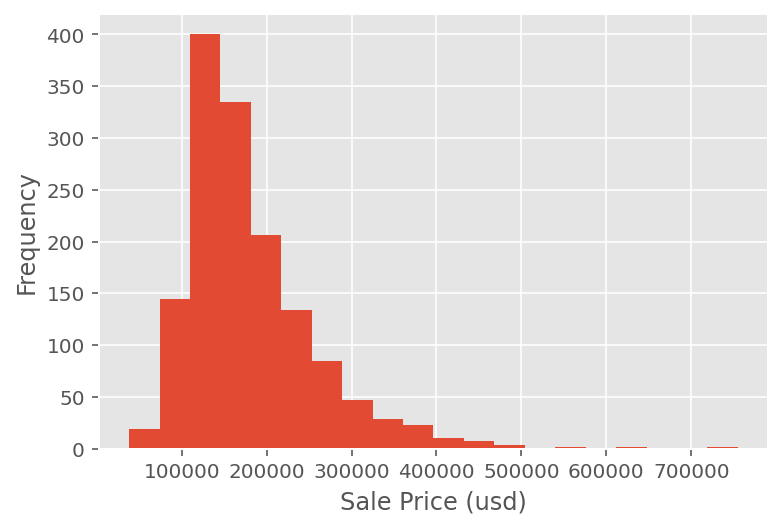

In [138]:
plt.hist(residents.SalePrice, bins = 20)
plt.xlabel("Sale Price (usd)")
plt.ylabel('Frequency');

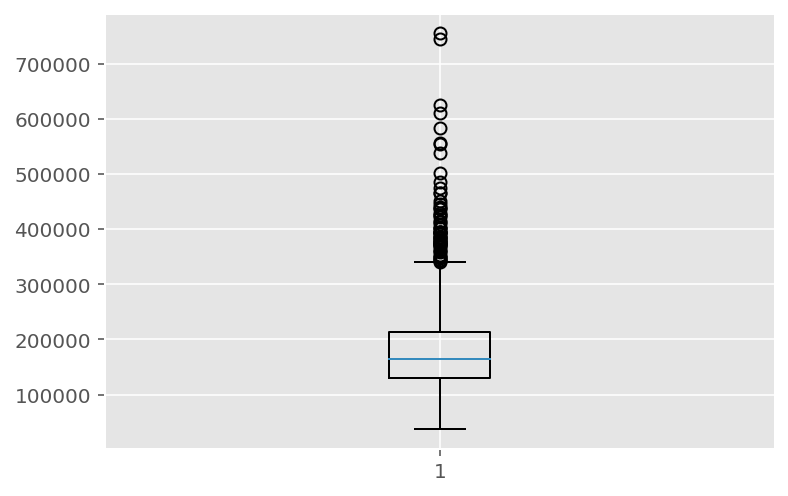

In [139]:
plt.boxplot(residents.SalePrice);

In [140]:
fixed = ['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea','Street', 'Alley', 'LotShape', 'LandContour', 
        'Utilities', 'LotConfig','LandSlope','Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle','YearBuilt', 'YearRemodAdd','Foundation',  'BsmtQual', 'BsmtExposure', 'TotalBsmtSF', 
         '1stFlrSF', '2ndFlrSF','GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 
         'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageType', 'GarageYrBlt', 'GarageCars', 'GarageArea',
        'Pool', 'MiscVal', 'MoSold', 'YrSold', 'SaleType',
       'SaleCondition', 'SalePrice']

# Basement quality measures the height or headroom of the basement.  This is not easily renovated.
# So despite being called quality, it will be included in fixed features


changeable = ['OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtCond', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'LowQualFinSF', 
             'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual','GarageCond', 'PavedDrive', 
              'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'Fence', ]

In [141]:
# create df of just fixed, unchangeable variables
df = residents[fixed]
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,GarageYrBlt,GarageCars,GarageArea,Pool,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,...,2003.0,2,548,0,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,...,1976.0,2,460,0,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,...,2001.0,2,608,0,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,...,1998.0,3,642,0,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,...,2000.0,3,836,0,0,12,2008,WD,Normal,250000


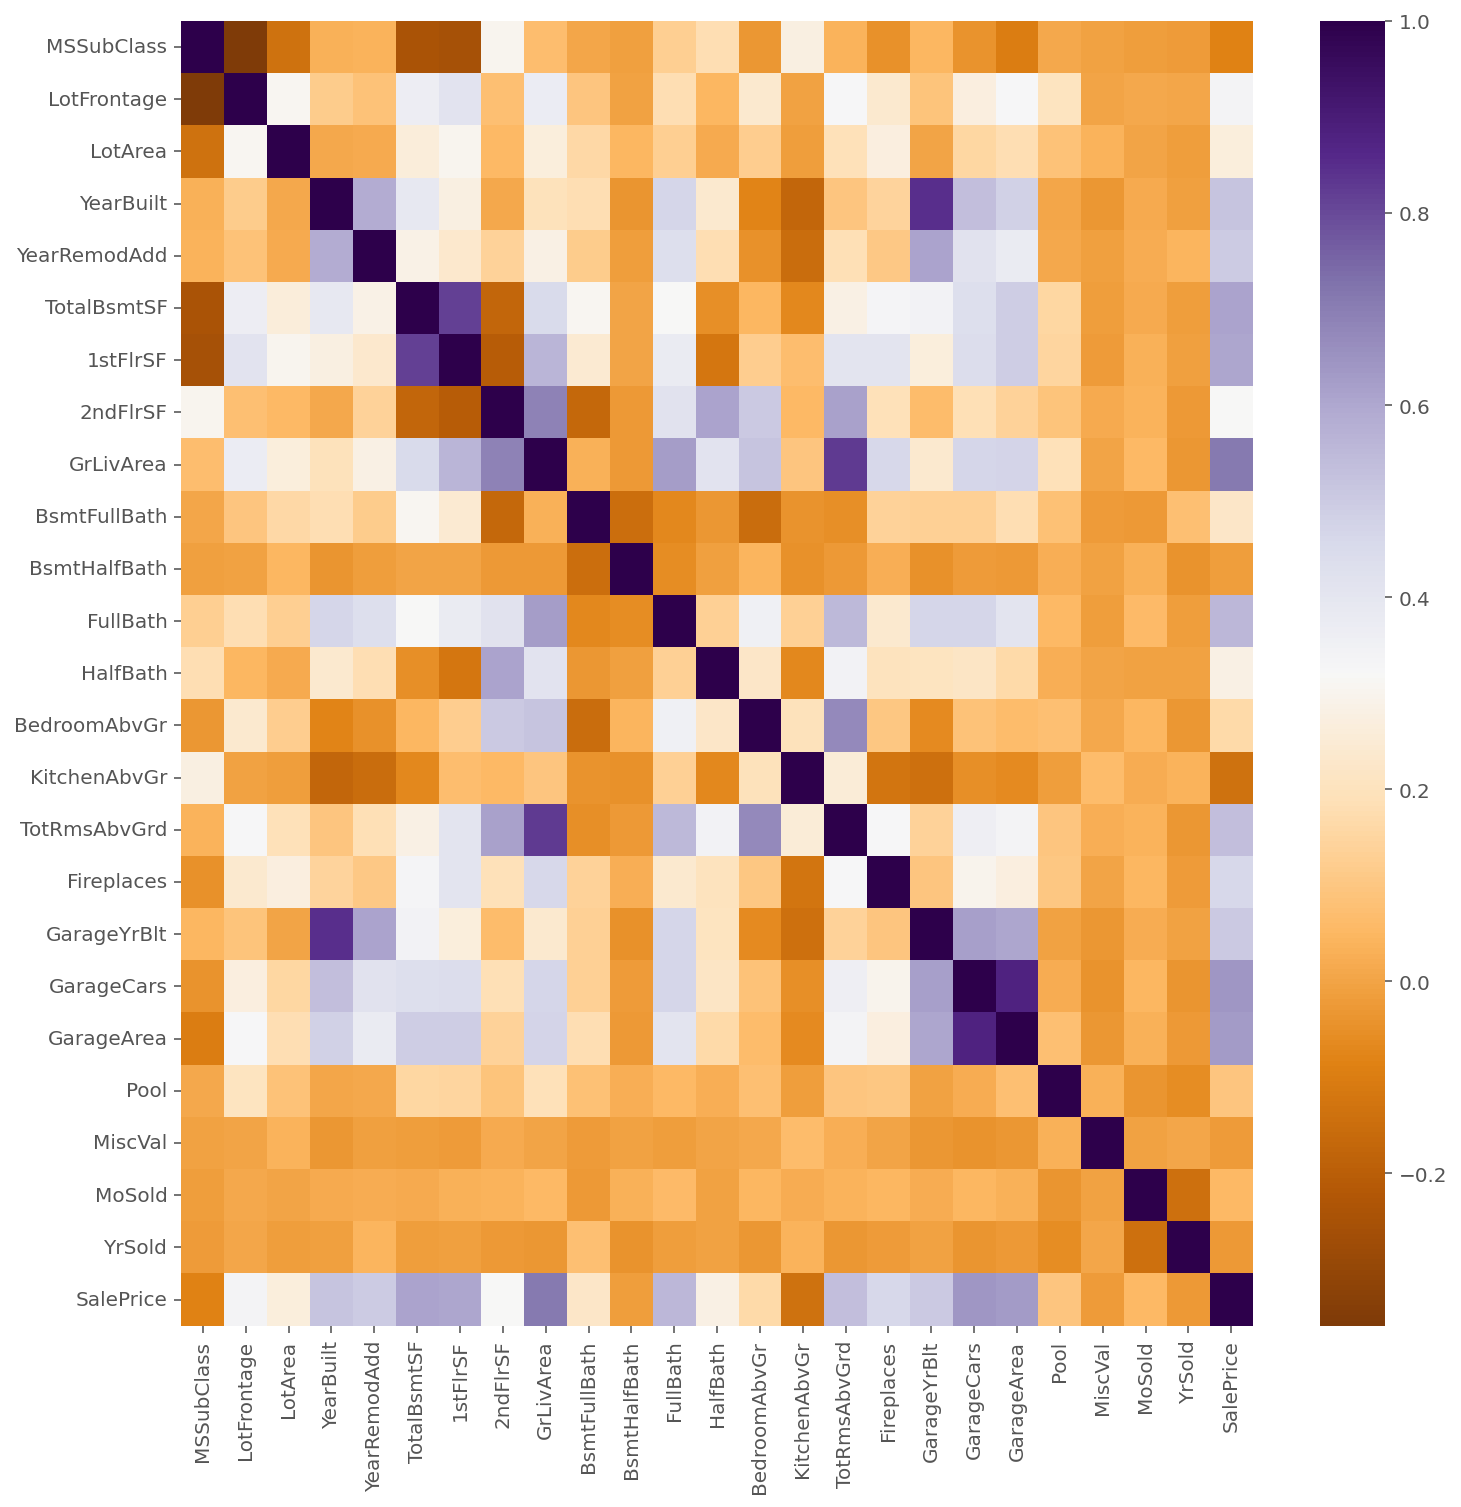

In [142]:
#lets look at any possible correlations between saleprice and other continuous variables

fig, ax = plt.subplots(figsize = (12,12))

ax = sns.heatmap(df.corr(), cmap = 'PuOr');

In [143]:
df.corr()

,MSSubClass,LotFrontage,LotArea,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,...,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,Pool,MiscVal,MoSold,YrSold,SalePrice
MSSubClass,1.000000,-0.358458,-0.139725,0.030056,0.035989,-0.242933,-0.256336,0.304606,0.069245,0.004554,...,0.034751,-0.049409,0.045034,-0.042209,-0.100045,0.008637,-0.007172,-0.015808,-0.019356,-0.087487
LotFrontage,-0.358458,1.000000,0.306396,0.118855,0.082589,0.363872,0.415628,0.075225,0.370985,0.093101,...,0.321916,0.237546,0.088040,0.270148,0.322754,0.208218,-0.000653,0.009678,0.005430,0.337567
LotArea,-0.139725,0.306396,1.000000,0.012958,0.013475,0.261034,0.299984,0.051568,0.264359,0.158232,...,0.190489,0.271941,0.001414,0.154124,0.179251,0.087149,0.037468,0.001500,-0.013579,0.264715
YearBuilt,0.030056,0.118855,0.012958,1.000000,0.590105,0.390050,0.277341,0.010472,0.196822,0.181910,...,0.095055,0.141373,0.848378,0.538183,0.484036,0.005254,-0.034681,0.017254,-0.009111,0.517602
YearRemodAdd,0.035989,0.082589,0.013475,0.590105,1.000000,0.285987,0.233655,0.138260,0.281259,0.115609,...,0.187457,0.104571,0.609865,0.421333,0.377573,0.009033,-0.009716,0.023540,0.040420,0.501186
TotalBsmtSF,-0.242933,0.363872,0.261034,0.390050,0.285987,1.000000,0.819138,-0.177026,0.452676,0.306864,...,0.283153,0.336607,0.346956,0.435102,0.490651,0.151272,-0.018544,0.014918,-0.013616,0.612088
1stFlrSF,-0.256336,0.415628,0.299984,0.277341,0.233655,0.819138,1.000000,-0.205486,0.564098,0.243866,...,0.408085,0.407514,0.264618,0.438864,0.493368,0.146826,-0.021095,0.033951,-0.012165,0.603300
2ndFlrSF,0.304606,0.075225,0.051568,0.010472,0.138260,-0.177026,-0.205486,1.000000,0.687450,-0.169987,...,0.615526,0.192997,0.061545,0.183655,0.139311,0.090204,0.016834,0.036036,-0.027041,0.319774
GrLivArea,0.069245,0.370985,0.264359,0.196822,0.281259,0.452676,0.564098,0.687450,1.000000,0.034180,...,0.825183,0.459269,0.237634,0.468693,0.474343,0.189874,-0.001811,0.052036,-0.034738,0.708658
BsmtFullBath,0.004554,0.093101,0.158232,0.181910,0.115609,0.306864,0.243866,-0.169987,0.034180,1.000000,...,-0.053697,0.135425,0.133804,0.130862,0.181082,0.076785,-0.022793,-0.024473,0.071433,0.224054


In [144]:
# are there any colinnear cols that are measuring v similar things? (from heatmap above)

# garage cars and area (>0.88)

# 1st flr sqft and basement sq ft > 0.81

# yearbuilt and year garage built >0.84

# TotRmsAbvGrd and GrLivArea > 0.82

# so let's remove some of these as there will be some colinnearity:

# garagecars (as area is likely more accurate)
# basement sq fr (as not all properties have a basement)
# yr garage built (not all houses have a garage)
# totrmsabvgrd (as living area is more replicable)

In [145]:
df.corr()['SalePrice'].sort_values(ascending = False)[1:]

GrLivArea       0.708658
GarageCars      0.642135
GarageArea      0.629831
TotalBsmtSF     0.612088
1stFlrSF        0.603300
FullBath        0.556674
TotRmsAbvGrd    0.533355
YearBuilt       0.517602
GarageYrBlt     0.506338
YearRemodAdd    0.501186
Fireplaces      0.463264
LotFrontage     0.337567
2ndFlrSF        0.319774
HalfBath        0.280882
LotArea         0.264715
BsmtFullBath    0.224054
BedroomAbvGr    0.162008
Pool            0.093703
MoSold          0.051987
BsmtHalfBath   -0.017561
MiscVal        -0.021052
YrSold         -0.025391
MSSubClass     -0.087487
KitchenAbvGr   -0.137825
Name: SalePrice, dtype: float64

In [146]:
# drop colinnearity cols from above:

df.drop(['GarageCars', 'GarageYrBlt', 'TotalBsmtSF', 'TotRmsAbvGrd'], inplace = True, axis = 1)

/var/folders/bm/2w01_g15327_2drgpr6m5jrm0000gn/T/ipykernel_61256/582763459.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['GarageCars', 'GarageYrBlt', 'TotalBsmtSF', 'TotRmsAbvGrd'], inplace = True, axis = 1)


In [147]:
df.dtypes

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
YearBuilt          int64
YearRemodAdd       int64
Foundation        object
BsmtQual          object
BsmtExposure      object
1stFlrSF           int64
2ndFlrSF           int64
GrLivArea          int64
BsmtFullBath       int64
BsmtHalfBath       int64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
Fireplaces         int64
GarageType        object
GarageArea         int64
Pool               int64
MiscVal            int64
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64


In [148]:
# what other object cols have only a few values and could potentially be removed?

df.SaleCondition.value_counts(normalize = True)

Normal     0.823448
Partial    0.086207
Abnorml    0.066207
Family     0.013793
Alloca     0.007586
AdjLand    0.002759
Name: SaleCondition, dtype: float64

In [149]:
df.groupby('SaleCondition')['SalePrice'].mean()

# all have quite different means, so perhaps leave as separate as they all seem to have an affect

SaleCondition
Abnorml    150758.354167
AdjLand    104125.000000
Alloca     177503.272727
Family     149600.000000
Normal     175485.225293
Partial    272291.752000
Name: SalePrice, dtype: float64

In [150]:
df.SaleType.value_counts(normalize = True)

WD       0.869655
New      0.084138
COD      0.028276
ConLD    0.004828
ConLI    0.003448
ConLw    0.003448
CWD      0.002759
Oth      0.002069
Con      0.001379
Name: SaleType, dtype: float64

In [151]:
df.groupby('SaleType')['SalePrice'].mean()

SaleType
COD      146693.902439
CWD      210600.000000
Con      269600.000000
ConLD    154718.285714
ConLI    200390.000000
ConLw    143700.000000
New      274945.418033
Oth      119850.000000
WD       173907.412371
Name: SalePrice, dtype: float64

In [152]:
df.Foundation.value_counts(normalize = True)

PConc     0.446207
CBlock    0.432414
BrkTil    0.099310
Slab      0.016552
Stone     0.003448
Wood      0.002069
Name: Foundation, dtype: float64

In [153]:
df.groupby('Foundation')['SalePrice'].mean()

# stone and wood means aren't dissimilar.  Will reclassify those as other (see below) 

Foundation
BrkTil    132920.812500
CBlock    150730.811802
PConc     225230.442040
Slab      107365.625000
Stone     178595.800000
Wood      185666.666667
Name: SalePrice, dtype: float64

In [154]:
df.Street.value_counts()

Pave    1446
Grvl       4
Name: Street, dtype: int64

In [155]:
df.groupby('Street')['SalePrice'].median()

Street
Grvl    152600.0
Pave    163945.0
Name: SalePrice, dtype: float64

In [156]:
df.Utilities.value_counts()

AllPub    1449
NoSeWa       1
Name: Utilities, dtype: int64

In [157]:
df.Alley.value_counts(normalize = True)

None    0.938621
Grvl    0.034483
Pave    0.026897
Name: Alley, dtype: float64

In [158]:
df.groupby('Alley')['SalePrice'].mean()

# paved and gravel alleys seem to have lower sale prices than no alley.  
# But both means are considerably diff from each other!

Alley
Grvl    122219.080000
None    184087.776635
Pave    172955.076923
Name: SalePrice, dtype: float64

In [159]:
df.Condition2.value_counts(normalize = True)

Norm      0.990345
Feedr     0.003448
Artery    0.001379
RRNn      0.001379
PosN      0.001379
PosA      0.000690
RRAn      0.000690
RRAe      0.000690
Name: Condition2, dtype: float64

In [160]:
# utilities, street both have only 2 cats with very few in 1. 
# Condition 2 also has over 99% of it's values in one category Let's drop
df.drop(['Street', 'Utilities', 'Condition2'], inplace = True, axis = 1)

/var/folders/bm/2w01_g15327_2drgpr6m5jrm0000gn/T/ipykernel_61256/1051679899.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['Street', 'Utilities', 'Condition2'], inplace = True, axis = 1)


In [161]:
# let's also group stone and wood foundations as other, since both have a low value count and similar means:
df['Foundation'] = df['Foundation'].replace(['Wood', 'Stone'], 'Other')

/var/folders/bm/2w01_g15327_2drgpr6m5jrm0000gn/T/ipykernel_61256/2680623557.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Foundation'] = df['Foundation'].replace(['Wood', 'Stone'], 'Other')


In [162]:
# what do we have left now?  And do they all have some sort of sginificant effect on the sale price?
df.corr()['SalePrice'].sort_values(ascending = False)[1:]

GrLivArea       0.708658
GarageArea      0.629831
1stFlrSF        0.603300
FullBath        0.556674
YearBuilt       0.517602
YearRemodAdd    0.501186
Fireplaces      0.463264
LotFrontage     0.337567
2ndFlrSF        0.319774
HalfBath        0.280882
LotArea         0.264715
BsmtFullBath    0.224054
BedroomAbvGr    0.162008
Pool            0.093703
MoSold          0.051987
BsmtHalfBath   -0.017561
MiscVal        -0.021052
YrSold         -0.025391
MSSubClass     -0.087487
KitchenAbvGr   -0.137825
Name: SalePrice, dtype: float64

In [163]:
# still quite a few cols (which will be even more when some are dummified)
# and a good few have a correlation less than 0.2 and greater than -0.2
# it seems as though few fixed conditions have negative corr 
# (likely conditions that subtract from price are quality based)
# will remove those will low corr values to reduce poor quality info passed to model
# YrSold remains so we can split into train and test data and will be removed later

In [164]:
# looking at these it makes sense to drop them in comparison to others:
#MSSubClass surely contains similar info to yrbuilt and housestyle annd building type;
# Kitchen and Bedroom above ground will likely be affected by 1st and 2nd floor sqfoot
#basement half bath - surely that's just a toilet in the basement?  Not huge selling point compared to full bathroom
df.drop(['BedroomAbvGr', 'Pool', 'MoSold','BsmtHalfBath', 'MiscVal', 'MSSubClass', 'KitchenAbvGr'], inplace = True, axis = 1)

/var/folders/bm/2w01_g15327_2drgpr6m5jrm0000gn/T/ipykernel_61256/3576960559.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['BedroomAbvGr', 'Pool', 'MoSold','BsmtHalfBath', 'MiscVal', 'MSSubClass', 'KitchenAbvGr'], inplace = True, axis = 1)


In [165]:
df.select_dtypes('object').columns

Index(['MSZoning', 'Alley', 'LotShape', 'LandContour', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle',
       'Foundation', 'BsmtQual', 'BsmtExposure', 'GarageType', 'SaleType',
       'SaleCondition'],
      dtype='object')

In [166]:
#what about non-numerical cols?  What if they have little value for our model?
# Dr google helped me find ANOVA test! Performing this will give a probabilty (P-Value)
# that the saleprice and the categorical variable have no correlation.  When P-Value > 0.05, we accept there is no correlation
from scipy.stats import f_oneway
catlist = df.groupby('MSZoning')['SalePrice'].apply(list)
# Performing the ANOVA test
AnovaResults = f_oneway (*catlist)
print ('P-Value for Anova is: ', AnovaResults[1])

P-Value for Anova is:  1.3152553502246802e-31


In [167]:
catlist = df.groupby('Alley')['SalePrice'].apply(list)
# Performing the ANOVA test
AnovaResults = f_oneway (*catlist)
print ('P-Value for Anova is: ', AnovaResults[1])

P-Value for Anova is:  2.763424737334942e-07


In [168]:
catlist = df.groupby('LotShape')['SalePrice'].apply(list)
# Performing the ANOVA test
AnovaResults = f_oneway (*catlist)
print ('P-Value for Anova is: ', AnovaResults[1])

P-Value for Anova is:  3.1604081489274916e-24


In [169]:
catlist = df.groupby('LandContour')['SalePrice'].apply(list)
# Performing the ANOVA test
AnovaResults = f_oneway (*catlist)
print ('P-Value for Anova is: ', AnovaResults[1])

P-Value for Anova is:  9.42311321468697e-09


In [170]:
catlist = df.groupby('LotConfig')['SalePrice'].apply(list)
# Performing the ANOVA test
AnovaResults = f_oneway (*catlist)
print ('P-Value for Anova is: ', AnovaResults[1])

P-Value for Anova is:  4.866098751606077e-06


In [171]:
catlist = df.groupby('LandSlope')['SalePrice'].apply(list)
# Performing the ANOVA test
AnovaResults = f_oneway (*catlist)
print ('P-Value for Anova is: ', AnovaResults[1])

P-Value for Anova is:  0.06628620730152941


In [172]:
catlist = df.groupby('Condition1')['SalePrice'].apply(list)
# Performing the ANOVA test
AnovaResults = f_oneway (*catlist)
print ('P-Value for Anova is: ', AnovaResults[1])

P-Value for Anova is:  1.4848137006044825e-07


In [173]:
catlist = df.groupby('BldgType')['SalePrice'].apply(list)
# Performing the ANOVA test
AnovaResults = f_oneway (*catlist)
print ('P-Value for Anova is: ', AnovaResults[1])

P-Value for Anova is:  9.154702325425534e-11


In [174]:
catlist = df.groupby('HouseStyle')['SalePrice'].apply(list)
# Performing the ANOVA test
AnovaResults = f_oneway (*catlist)
print ('P-Value for Anova is: ', AnovaResults[1])

P-Value for Anova is:  1.0505568294261704e-24


In [175]:
catlist = df.groupby('Foundation')['SalePrice'].apply(list)
# Performing the ANOVA test
AnovaResults = f_oneway (*catlist)
print ('P-Value for Anova is: ', AnovaResults[1])

P-Value for Anova is:  3.4220171380110915e-90


In [176]:
catlist = df.groupby('BsmtQual')['SalePrice'].apply(list)
# Performing the ANOVA test
AnovaResults = f_oneway (*catlist)
print ('P-Value for Anova is: ', AnovaResults[1])

P-Value for Anova is:  1.0391621958923581e-193


In [177]:
catlist = df.groupby('BsmtExposure')['SalePrice'].apply(list)
# Performing the ANOVA test
AnovaResults = f_oneway (*catlist)
print ('P-Value for Anova is: ', AnovaResults[1])

P-Value for Anova is:  3.079765184427661e-50


In [178]:
catlist = df.groupby('GarageType')['SalePrice'].apply(list)
# Performing the ANOVA test
AnovaResults = f_oneway (*catlist)
print ('P-Value for Anova is: ', AnovaResults[1])

P-Value for Anova is:  4.509927888764435e-84


In [179]:
catlist = df.groupby('SaleType')['SalePrice'].apply(list)
# Performing the ANOVA test
AnovaResults = f_oneway (*catlist)
print ('P-Value for Anova is: ', AnovaResults[1])

P-Value for Anova is:  4.0145467571541846e-41


In [180]:
catlist = df.groupby('SaleCondition')['SalePrice'].apply(list)
# Performing the ANOVA test
AnovaResults = f_oneway (*catlist)
print ('P-Value for Anova is: ', AnovaResults[1])

P-Value for Anova is:  1.2080233795151565e-42


In [181]:
#well at least it looks like LandSlope has little effect, so we'll remove
df.drop('LandSlope', inplace = True, axis = 1)
df.head()

/var/folders/bm/2w01_g15327_2drgpr6m5jrm0000gn/T/ipykernel_61256/1461138826.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('LandSlope', inplace = True, axis = 1)


,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,Neighborhood,Condition1,BldgType,...,BsmtFullBath,FullBath,HalfBath,Fireplaces,GarageType,GarageArea,YrSold,SaleType,SaleCondition,SalePrice
0,RL,65.0,8450,None,Reg,Lvl,Inside,CollgCr,Norm,1Fam,...,1,2,1,0,Attchd,548,2008,WD,Normal,208500
1,RL,80.0,9600,None,Reg,Lvl,FR2,Veenker,Feedr,1Fam,...,0,2,0,1,Attchd,460,2007,WD,Normal,181500
2,RL,68.0,11250,None,IR1,Lvl,Inside,CollgCr,Norm,1Fam,...,1,2,1,1,Attchd,608,2008,WD,Normal,223500
3,RL,60.0,9550,None,IR1,Lvl,Corner,Crawfor,Norm,1Fam,...,1,1,0,1,Detchd,642,2006,WD,Abnorml,140000
4,RL,84.0,14260,None,IR1,Lvl,FR2,NoRidge,Norm,1Fam,...,1,2,1,1,Attchd,836,2008,WD,Normal,250000


In [182]:
#create a list of object cols to dummify

dummycols = list(df.columns[df.dtypes==object])
dummycols

['MSZoning',
 'Alley',
 'LotShape',
 'LandContour',
 'LotConfig',
 'Neighborhood',
 'Condition1',
 'BldgType',
 'HouseStyle',
 'Foundation',
 'BsmtQual',
 'BsmtExposure',
 'GarageType',
 'SaleType',
 'SaleCondition']

In [183]:
# create a list of int and float cols to standardize

numcols = list(df.columns[df.dtypes!=object])
numcols

['LotFrontage',
 'LotArea',
 'YearBuilt',
 'YearRemodAdd',
 '1stFlrSF',
 '2ndFlrSF',
 'GrLivArea',
 'BsmtFullBath',
 'FullBath',
 'HalfBath',
 'Fireplaces',
 'GarageArea',
 'YrSold',
 'SalePrice']

In [184]:
# remove 'YrSold' and 'SalePrice' from numcols so they aren't standardized 
numcols.remove('YrSold')
numcols.remove('SalePrice')

In [185]:
df= pd.get_dummies(df, columns = dummycols, drop_first = True)
df.head()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,65.0,8450,2003,2003,856,854,1710,1,2,1,...,0,0,0,0,1,0,0,0,1,0
1,80.0,9600,1976,1976,1262,0,1262,0,2,0,...,0,0,0,0,1,0,0,0,1,0
2,68.0,11250,2001,2002,920,866,1786,1,2,1,...,0,0,0,0,1,0,0,0,1,0
3,60.0,9550,1915,1970,961,756,1717,1,1,0,...,0,0,0,0,1,0,0,0,0,0
4,84.0,14260,2000,2000,1145,1053,2198,1,2,1,...,0,0,0,0,1,0,0,0,1,0


In [186]:
# dummifying all object cols gives 103 columns! 
# But it would have been far greater if we hadn't dropped & cleaned! (my first dummifying was approx 131 cols!)
# So hopefully this has given less 'noise' to the linreg models and will make the models more accurate
# now standardize numerical cols

In [187]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

df[numcols]=scaler.fit_transform(df[numcols])

In [188]:
df.head()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,-0.229094,-0.207202,1.046466,0.873699,-0.798869,1.159430,0.366307,1.102461,0.784613,1.222335,...,0,0,0,0,1,0,0,0,1,0
1,0.452267,-0.092303,0.146836,-0.440475,0.251549,-0.795056,-0.487070,-0.823525,0.784613,-0.764645,...,0,0,0,0,1,0,0,0,1,0
2,-0.092822,0.072553,0.979827,0.825026,-0.633286,1.186894,0.511076,1.102461,0.784613,1.222335,...,0,0,0,0,1,0,0,0,1,0
3,-0.456214,-0.097298,-1.885661,-0.732513,-0.527209,0.935145,0.379641,1.102461,-1.035690,-0.764645,...,0,0,0,0,1,0,0,0,0,0
4,0.633963,0.373291,0.946507,0.727680,-0.051158,1.614867,1.295879,1.102461,0.784613,1.222335,...,0,0,0,0,1,0,0,0,1,0


In [189]:
# split into pre and post 2010:

X_train = df[(df.YrSold < 2010)]
X_test = df[(df.YrSold >= 2010)]

In [190]:
print(X_train.shape)
print(X_test.shape)

(1278, 103)
(172, 103)


In [191]:
#removing YrSold as stated earlier

X_train.drop('YrSold', inplace = True, axis = 1)
X_test.drop('YrSold', inplace = True, axis = 1)

/var/folders/bm/2w01_g15327_2drgpr6m5jrm0000gn/T/ipykernel_61256/3609553128.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.drop('YrSold', inplace = True, axis = 1)
/var/folders/bm/2w01_g15327_2drgpr6m5jrm0000gn/T/ipykernel_61256/3609553128.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.drop('YrSold', inplace = True, axis = 1)


In [192]:
# pop out SalePrice to create y and finalise X
y_train= X_train.pop('SalePrice')
y_test = X_test.pop("SalePrice")

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1278, 101)
(172, 101)
(1278,)
(172,)


In [193]:
from sklearn.linear_model import LinearRegression

In [194]:
from sklearn.model_selection import cross_val_score

In [195]:
model = LinearRegression()

In [196]:
model.fit(X_train, y_train)

model.score(X_train, y_train)

0.8547615513780213

In [197]:
# that's a nice, high, positive R2 score.  Let's validate it and then evaluate it on the test data

from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X_train, y_train, cv=5)

print(cv_scores)
print(np.mean(cv_scores))
print(np.median(cv_scores))

[ 8.49888338e-01 -4.71596297e+23  8.31982018e-01 -4.08427356e+23
  7.08930608e-01]
-1.7600473055550735e+23
0.7089306084838001


In [198]:
# cross val scores are not what we wanted to see! But that could be because we have 101 cols and creating crossval
# makes the sample size comparatively small and this is seen when looking at median score.  Lets see how it looks on the test data

model.fit(X_test,y_test)
model.score(X_test,y_test)

0.9258791294745575

In [199]:
# now check if Ridge, Lasso or Elastic Net improve.  If we use Elastic net CV to get optimal alpha and optimal l1 ratio
# if l1 ratio is 1, then Lasso is better, 0 means Ridge is better.  Anywhere between 0 and 1, Enet is better

from sklearn.linear_model import ElasticNet, ElasticNetCV

# define a range of l1 ratios to try
l1_ratios = np.linspace(0.1, 1.0, 25)

# give ElasticNetCV this range of L1 ratios and a number of alphas to try.  We don't want to give it too much to do
# as it can be quite a slow computational process
# define this model with our optimal l1 ratio and alpha as our optimal Enet model
optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=100, cv=10,
                            verbose=1, n_jobs=2)

# fit our optimal Enet to the training set
optimal_enet.fit(X_train, y_train)

#print out the alpah and l1 ratio of the optimal 
print(optimal_enet.alpha_)
print(optimal_enet.l1_ratio_)



[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

98.42493762688729
1.0


In [200]:
#so we're effectively using Lasso.  Let's apply it to the training and test data and see if it's better than original model

print('Original model train score was: ', model.score(X_train, y_train))
print('Original model test score was: ', model.score(X_test, y_test))
print('Enet train score is: ', optimal_enet.score(X_train, y_train))
print('Enet test score is: ', optimal_enet.score(X_test, y_test))

Original model train score was:  -1.7339034456333355e+25
Original model test score was:  0.9258791294745575
Enet train score is:  0.8478498459694219
Enet test score is:  0.8634773532171401


In [201]:
# Lasso is marginally better on test data.  Which is an improvement and better for using in future on non training data
# Let's see what the coefs and residuals are like:

Enet_coefs = pd.DataFrame({'variable': X_train.columns,
                            'coef': optimal_enet.coef_,
                            'abs_coef': np.abs(optimal_enet.coef_)})

Enet_coefs.sort_values('abs_coef', inplace=True, ascending=False)

Enet_coefs.head(20)

,variable,coef,abs_coef
41,Neighborhood_NoRidge,63406.161330,63406.161330
48,Neighborhood_StoneBr,58177.841680,58177.841680
42,Neighborhood_NridgHt,48815.345833,48815.345833
77,BsmtQual_TA,-39282.296203,39282.296203
74,BsmtQual_Fa,-39195.192843,39195.192843
75,BsmtQual_Gd,-39023.812074,39023.812074
76,BsmtQual_None,-35532.299930,35532.299930
6,GrLivArea,25252.710069,25252.710069
61,BldgType_Twnhs,-24283.421416,24283.421416
32,Neighborhood_Crawfor,23149.618027,23149.618027


In [202]:
# coefs are quite large! But then so is the SalePrice
# otherwise it may suggest that there's still some variables in there that are just noise
# One of the biggest indicators seems to be the neighbourhood (8 out of top 20) suggesting sig variation in quality of area

In [203]:
# what percentage of variables have been zeroed out by Lasso?
print('Percent variables zeroed out:', np.sum(
    (np.abs(optimal_enet.coef_) == 0))/float(X_train.shape[1]))

Percent variables zeroed out: 0.3564356435643564


In [204]:
# so about 35 of our cols have very little effect.  Which are they?
Enet_coefs[Enet_coefs.coef == 0].sort_values('variable')

,variable,coef,abs_coef
16,Alley_Pave,-0.0,0.0
53,Condition1_PosA,0.0,0.0
54,Condition1_PosN,-0.0,0.0
56,Condition1_RRAn,0.0,0.0
57,Condition1_RRNe,0.0,0.0
58,Condition1_RRNn,0.0,0.0
71,Foundation_Other,-0.0,0.0
83,GarageType_Basment,-0.0,0.0
84,GarageType_BuiltIn,0.0,0.0
87,GarageType_None,0.0,0.0


In [205]:
# in hindsight a few variables could have been either removed or could have renamed some of the conditions together!

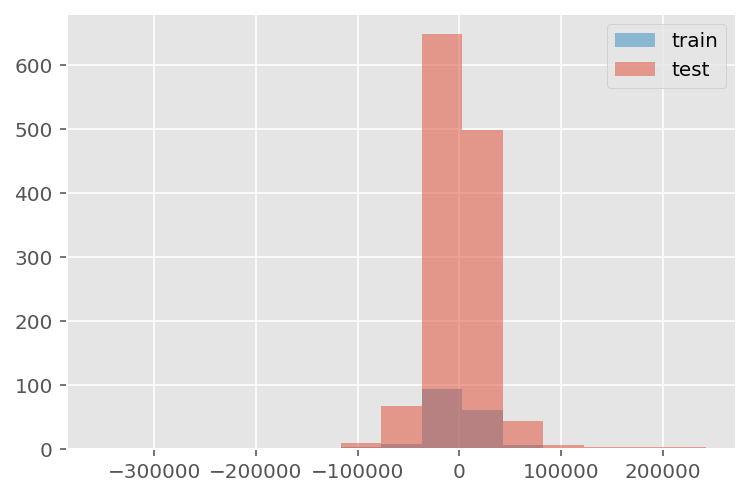

In [206]:
#residuals? does it particularly over or underestimate?

residtrain = y_train - optimal_enet.predict(X_train)
residtest = y_test - optimal_enet.predict(X_test)

plt.hist([residtrain, residtest], bins=15, histtype='stepfilled', alpha=0.5)
plt.legend(['train', 'test'])
plt.show()

Residuals areroughly normally distributed for both test and train data, with slightly more residuals on the negative, so perhaps our model slightly underestimates.  But R2 scores are good and it seems ot be pretty accurate
The biggest factors on the sale price look to be:
- the neighbourhood; some neighbourhood are more expensive than others and some have negative coeficients, so it suggests some neighbours are likely to bring the sale price down
- the size (general living area).  The larger the general living area, the higher the sale price
- if a property has an excellent qualilty basement or not.  An excellent quality basement increases the price, whereas very low quality basements (measured by smaller headrooms) seem to reduce the price more than not having a basement at all 
- the type of building - a few types are always going to fetch a far lower price and seemingly fingle family detached (the baseline for the dummified col) is more expensive than types of townhouses and duplexes.

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovatable features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [207]:
# create another df but including only changeable features that can be easily renovated, sale price and year sold

changeable = ['OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'BsmtCond', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'LowQualFinSF', 
             'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual','GarageCond', 'PavedDrive', 
              'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'Fence', 'YrSold', 'SalePrice']

fixup = residents[changeable]

fixup.head()

,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,BsmtCond,...,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,Fence,YrSold,SalePrice
0,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,TA,...,TA,Y,0,61,0,0,0,None,2008,208500
1,6,8,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,TA,...,TA,Y,298,0,0,0,0,None,2007,181500
2,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,TA,...,TA,Y,0,42,0,0,0,None,2008,223500
3,7,5,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,Gd,...,TA,Y,0,35,272,0,0,None,2006,140000
4,8,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,TA,...,TA,Y,192,84,0,0,0,None,2008,250000


In [208]:
# what types or data do we have in our cols?

fixup.dtypes

OverallQual       int64
OverallCond       int64
RoofStyle        object
RoofMatl         object
Exterior1st      object
Exterior2nd      object
MasVnrType       object
ExterQual        object
ExterCond        object
BsmtCond         object
BsmtFinType1     object
BsmtFinSF1        int64
BsmtFinType2     object
BsmtFinSF2        int64
BsmtUnfSF         int64
Heating          object
HeatingQC        object
CentralAir       object
Electrical       object
LowQualFinSF      int64
KitchenQual      object
Functional       object
FireplaceQu      object
GarageFinish     object
GarageQual       object
GarageCond       object
PavedDrive       object
WoodDeckSF        int64
OpenPorchSF       int64
EnclosedPorch     int64
3SsnPorch         int64
ScreenPorch       int64
Fence            object
YrSold            int64
SalePrice         int64
dtype: object

In [209]:
# mix of numerical measurements finishes or decking etc that will be standardized,
# object cols that measure type that will be dummified
# object cols that measure quality and condition that should be ordinal

In [210]:
standcols = list(fixup.columns[fixup.dtypes == 'int64'])
standcols.remove('OverallQual')
standcols.remove('OverallCond')
standcols.remove('YrSold')
standcols.remove('SalePrice')
standcols

['BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'LowQualFinSF',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch']

In [211]:
# from data description; following columns are categorical and will be dummified:
conditional = ['RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Heating', 'CentralAir',
               'Electrical', 'Functional', 'GarageFinish', 'PavedDrive', 'Fence', 'BsmtFinType1', 'BsmtFinType2']

# the rest of the object type cols seem to have the same scale, with an obvious order to their values
# i.e. Excellent is better than Good, which is better than Average...
# so we should be able to confidently make these ordinal.  But what to do about NA? Is that a zero/baseline value?
# or is it better not to have a basement than have one in a poor quality?


In [212]:
ordinal = [x for x in fixup.columns[fixup.dtypes == 'object'] if x not in conditional]
ordinal

['ExterQual',
 'ExterCond',
 'BsmtCond',
 'HeatingQC',
 'KitchenQual',
 'FireplaceQu',
 'GarageQual',
 'GarageCond']

In [213]:
fixup.groupby('BsmtCond')['SalePrice'].mean()

BsmtCond
Fa      122384.395349
Gd      213599.907692
None    105652.891892
Po       64000.000000
TA      184356.090560
Name: SalePrice, dtype: float64

In [214]:
fixup.groupby('FireplaceQu')['SalePrice'].mean()

FireplaceQu
Ex      337712.500000
Fa      167298.484848
Gd      226595.350923
None    142301.531571
Po      129764.150000
TA      205723.488818
Name: SalePrice, dtype: float64

In [215]:
fixup.groupby('GarageQual')['SalePrice'].mean()

GarageQual
Ex      241000.000000
Fa      123573.354167
Gd      215860.714286
None    104415.189873
Po      100166.666667
TA      188161.009210
Name: SalePrice, dtype: float64

In [216]:
# looks like for those that have None as a possible value, poor is lower than None,
# which means we could assign an ordinal scale as such:
# Po -1, None 0, Fa 1, TA 2, Gd 3, Ex 4

scale = {'Po' : -1, 'None': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}

for col in ordinal:
    fixup[col] = fixup[col].map(scale)

/var/folders/bm/2w01_g15327_2drgpr6m5jrm0000gn/T/ipykernel_61256/3990991471.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fixup[col] = fixup[col].map(scale)
/var/folders/bm/2w01_g15327_2drgpr6m5jrm0000gn/T/ipykernel_61256/3990991471.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fixup[col] = fixup[col].map(scale)
/var/folders/bm/2w01_g15327_2drgpr6m5jrm0000gn/T/ipykernel_61256/3990991471.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

In [217]:
fixup.GarageQual.unique()

array([ 2,  1,  3,  0,  4, -1])

In [218]:
fixup.groupby('GarageQual')['SalePrice'].mean()

GarageQual
-1    100166.666667
 0    104415.189873
 1    123573.354167
 2    188161.009210
 3    215860.714286
 4    241000.000000
Name: SalePrice, dtype: float64

In [219]:
# so that's the ordinal cols sorted, let's standardize and dummify the remaining cols so we can apply some regression models

fixup= pd.get_dummies(fixup, columns = conditional, drop_first = True)
fixup.head()

,OverallQual,OverallCond,ExterQual,ExterCond,BsmtCond,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,HeatingQC,LowQualFinSF,...,BsmtFinType1_LwQ,BsmtFinType1_None,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_None,BsmtFinType2_Rec,BsmtFinType2_Unf
0,7,5,3,2,2,706,0,150,4,0,...,0,0,0,0,0,0,0,0,0,1
1,6,8,2,2,2,978,0,284,4,0,...,0,0,0,0,0,0,0,0,0,1
2,7,5,3,2,2,486,0,434,4,0,...,0,0,0,0,0,0,0,0,0,1
3,7,5,2,2,3,216,0,540,3,0,...,0,0,0,0,0,0,0,0,0,1
4,8,5,3,2,2,655,0,490,4,0,...,0,0,0,0,0,0,0,0,0,1


In [220]:
fixup[standcols]=scaler.fit_transform(fixup[standcols])

In [221]:
fixup.head()

,OverallQual,OverallCond,ExterQual,ExterCond,BsmtCond,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,HeatingQC,LowQualFinSF,...,BsmtFinType1_LwQ,BsmtFinType1_None,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_None,BsmtFinType2_Rec,BsmtFinType2_Unf
0,7,5,3,2,2,0.571765,-0.28973,-0.943367,4,-0.11789,...,0,0,0,0,0,0,0,0,0,1
1,6,8,2,2,2,1.167999,-0.28973,-0.640495,4,-0.11789,...,0,0,0,0,0,0,0,0,0,1
2,7,5,3,2,2,0.089517,-0.28973,-0.301460,4,-0.11789,...,0,0,0,0,0,0,0,0,0,1
3,7,5,2,2,3,-0.502333,-0.28973,-0.061876,3,-0.11789,...,0,0,0,0,0,0,0,0,0,1
4,8,5,3,2,2,0.459971,-0.28973,-0.174887,4,-0.11789,...,0,0,0,0,0,0,0,0,0,1


In [222]:
# split into pre and post 2010:

X_train = fixup[(fixup.YrSold < 2010)]
X_test = fixup[(fixup.YrSold >= 2010)]

print(X_train.shape)
print(X_test.shape)

(1278, 103)
(172, 103)


In [223]:
#removing YrSold as stated earlier

X_train.drop('YrSold', inplace = True, axis = 1)
X_test.drop('YrSold', inplace = True, axis = 1)

/var/folders/bm/2w01_g15327_2drgpr6m5jrm0000gn/T/ipykernel_61256/3609553128.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.drop('YrSold', inplace = True, axis = 1)
/var/folders/bm/2w01_g15327_2drgpr6m5jrm0000gn/T/ipykernel_61256/3609553128.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.drop('YrSold', inplace = True, axis = 1)


In [224]:
# pop out SalePrice to create y and finalise X
y_train= X_train.pop('SalePrice')
y_test = X_test.pop("SalePrice")

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1278, 101)
(172, 101)
(1278,)
(172,)


In [225]:
linreg = LinearRegression()

In [226]:
linreg.fit(X_train, y_train)
trainscore = linreg.score(X_train, y_train)
trainscore

0.7863186216801565

In [227]:
linreg.fit(X_test, y_test)
testscore = linreg.score(X_test, y_test)
testscore

0.8925875917738064

In [228]:
# once again promising R2 scores for both train and test data.  We'll see if ElasticNet can improve them

In [229]:
# define a range of l1 ratios to try
l1_ratios = np.linspace(0.1, 1.0, 25)

# give ElasticNetCV this range of L1 ratios and a number of alphas to try.  We don't want to give it too much to do
# as it can be quite a slow computational process
# define this model with our optimal l1 ratio and alpha as our optimal Enet model
best_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=100, cv=10,
                            verbose=1, n_jobs=2)

# fit our optimal Enet to the training set
best_enet.fit(X_train, y_train)

#print out the alpah and l1 ratio of the optimal 
print(best_enet.alpha_)
print(best_enet.l1_ratio_)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

862.375626149525
1.0


.............................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=2)]: Done 250 out of 250 | elapsed:    3.9s finished


In [230]:
#so we're effectively using Lasso.  Let's apply it to the training and test data and see if it's better than original model

print('Original model train score was: ', trainscore)
print('Original model test score was: ', testscore)
print('Enet train score is: ', best_enet.score(X_train, y_train))
print('Enet test score is: ', best_enet.score(X_test, y_test))

Original model train score was:  0.7863186216801565
Original model test score was:  0.8925875917738064
Enet train score is:  0.732565452041294
Enet test score is:  0.7687665526952963


In [231]:
# So lasso doesn't perform any better on training or testing data.  However, it will have scaled the coefs better
# and will have zeroed some, making the coefficients more interpretable
# So let's look at the coefs for the enet model

modelcoefs = pd.DataFrame({'variable': X_train.columns,
                            'coef': best_enet.coef_,
                            'abs_coef': np.abs(best_enet.coef_)})

modelcoefs.sort_values('abs_coef', inplace=True, ascending=False)

modelcoefs.head(20)

,variable,coef,abs_coef
0,OverallQual,25603.870857,25603.870857
5,BsmtFinSF1,16620.372822,16620.372822
10,KitchenQual,13183.427444,13183.427444
2,ExterQual,11936.798654,11936.798654
7,BsmtUnfSF,7660.796233,7660.796233
11,FireplaceQu,7348.620180,7348.620180
14,WoodDeckSF,6916.018233,6916.018233
15,OpenPorchSF,4191.214038,4191.214038
6,BsmtFinSF2,4052.022659,4052.022659
19,RoofStyle_Gable,-3897.272595,3897.272595


In [232]:
# so about the cols have very little effect.  Which are they?
modelcoefs[modelcoefs.coef == 0].sort_values('variable')

,variable,coef,abs_coef
89,BsmtFinType1_BLQ,-0.0,0.0
90,BsmtFinType1_GLQ,0.0,0.0
91,BsmtFinType1_LwQ,-0.0,0.0
92,BsmtFinType1_None,0.0,0.0
93,BsmtFinType1_Rec,-0.0,0.0
...,...,...,...
30,RoofMatl_WdShngl,0.0,0.0
20,RoofStyle_Gambrel,0.0,0.0
21,RoofStyle_Hip,0.0,0.0
22,RoofStyle_Mansard,0.0,0.0


There's 84 variables that seemingly have very little effect on the saleprice.  
However some have a significant effect on the saleprice.  For example, overallquality - each unit improvement is effectively a $25,000 increase in sale price.  However this is very difficult to pinpoint where these changes will come from as it's a measure of the entire house and not specific to a particular area

Basment finish type 1 - an increase of 1 standard deviation of this variable is worth around $16,000.  But unfinished area also shows a positive correlation.  Which suggests a larger basement increases the sale price.  Similarly, decking and open porch area both have strong positive effects on price.  However this is likely due to the sizes of these features being heavily linked and based on the overall size of the property.

Kitchen quality on the other hand seems to be something that could be targeted for improvements as 1 unit improvement is worth around 13000 USD.  In other words, improving a kitchen from average to good should increase the sale price by 13,000 USD.  
Likewise, the exterior quality can increase the price by around 12,000 USD for any improvements that change the quality by one rank (good to excellent etc).  
If there are fireplaces, improving them by one scale (poor to fair; fair to average etc) could increase sale price by around 7,000 USD
Finally, the heating quality and condition is related to roughly 2,000 USD increases for each sclae improvement.

In each case, the cost of the works obviously have to be factored in as to whether these works will increase profit on the house or just increase the overall sale price.

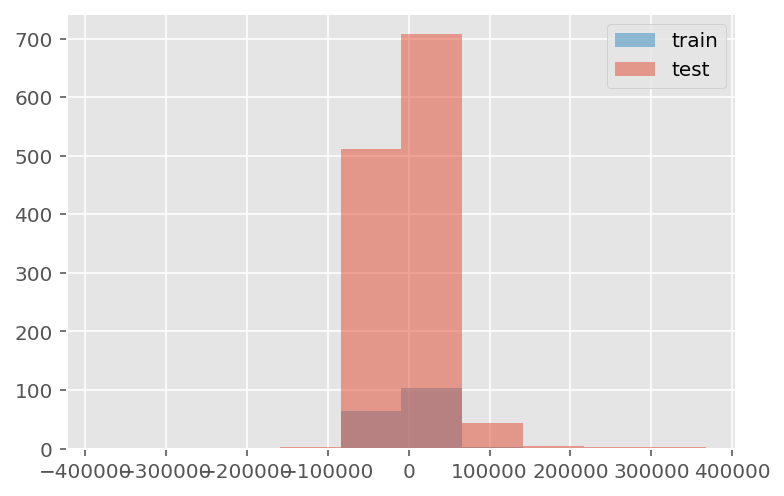

In [233]:
#residuals? does it particularly over or underestimate?

resid_train = y_train - best_enet.predict(X_train)
resid_test = y_test - best_enet.predict(X_test)

plt.hist([resid_train, resid_test], bins=10, histtype='stepfilled', alpha=0.5)
plt.legend(['train', 'test'])
plt.show()

In theory, the two properties could be used in conjunction with each other to calculate which properties to purchase and then do up.
The first model can be used to predict the saleprice of a house based on it's fixed features, giving the average sale price without considering changeable features, which would be assumed to be at the average. So if a house is listed as below this price, then there is potential for this house to reach greater value if certain features are improved.
This is where the second model should come in.  This can be used to estimate the increased price based on improvements made to certain characteristics and compared to the cost of making these changes.

The R^2 values are good which would suggest an accuracy rate that is reliable.  However I would have expected these to be significantly lower considering the R^2 values and coeficients for the original model.  My expectation is that the residuals would be far greater for the changeable characteristics than the fixed characteristics, since each property will always have a ceiling (that will vary as the market varies).  For example, the price of a smaller house in a lower price neighbourhood will only be able to get so high and as such the effect on the sale price of putting in a very high quality kitchen will be limited by the area and the property type.  This in theory should lead to a larger residual.
However, as previously mentioned, it does seem as though there are a number of changeable features that actually have colinnearity with fixed features.  So example the finish sq footage of the basement or outside of the house will be related to the overal size of the property and as such the general living size (one of the fixed variables).  

In [ ]:
# what about a model that can predict the residuals from the first model?  
# Could this be used to predict the differences in the sale prices from predicted values using the first model?
# let's start by creating a dataframe that has the cleaned and scaled changeable features and the residuals from the first model

In [234]:
# take the two lists of residuals created earlier, call them y_train and y_test
y_train = residtrain
y_test = residtest

print(y_train.shape)
print(y_test.shape)

(1278,)
(172,)


In [235]:
print(X_train.shape)
print(X_test.shape)

(1278, 101)
(172, 101)


In [236]:
# create another LR model with the new X and y

lr = LinearRegression()

lr.fit(X_train, y_train)

train_score = lr.score(X_train, y_train)
train_score

0.3214671558639046

In [237]:
# not as high, which sort of makes more sense.  I think... Let's test it on the test data

lr.fit(X_test, y_test)
test_score = lr.score(X_test, y_test)
test_score

0.47630091558618115

In [238]:
# That's an improvemen But it is a very small sample size AND we can always try using ENCV again...
# define a range of l1 ratios to try
l1_ratios = np.linspace(0.01, 1.0, 25)

# give ElasticNetCV this range of L1 ratios and a number of alphas to try.  We don't want to give it too much to do
# as it can be quite a slow computational process
# define this model with our optimal l1 ratio and alpha as our optimal Enet model
best_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=100, cv=10,
                            verbose=1, n_jobs=2)

# fit our optimal Enet to the training set
best_enet.fit(X_train, y_train)

#print out the alpah and l1 ratio of the optimal 
print(best_enet.alpha_)
print(best_enet.l1_ratio_)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

137.78943675658246
1.0


......................................................[Parallel(n_jobs=2)]: Done 250 out of 250 | elapsed:    4.1s finished


In [239]:
#looks like we are using lasso again
# compare to R2 value from original model to see if it's improved at all

print('Original model train score was: ', train_score)
print('Original model test score was: ', test_score)
print('Enet train score is: ', best_enet.score(X_train, y_train))
print('Enet test score is: ', best_enet.score(X_test, y_test))

Original model train score was:  0.3214671558639046
Original model test score was:  0.47630091558618115
Enet train score is:  0.1849902376605178
Enet test score is:  0.08998775433485928


So using a model to predict the residuals - i.e. the variances in the predictions from the original model to the actual sales price - doesn't look to be too succesful.  So linearregression without ridge, lasso etc (Enet (sing ridge gave even worse scores that were as good as 0) gave scores of 0.32 on the training data and 0.48 on the test data.  Normally we would only accept a model that was over .65.  So I'm not sure that we should accept this model (especially as the greatly improved score for the test data could well be due to the small sample size). 

IF we accept the first R^2 score then we could say that this model predicts roughly 32% of the variance in the first model (or 48% if we take the test data).  Which (assuming we take the R^2 score from the trianing data of 0.78) would mean it effectively takes our overall model to 0.85. 

However we'd likely need more data to be able to fine tune this model before it's used to base financial and business decisions on it, since you wouldn't normally accept a model unless it's around .65 or higher


<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. It is recommended to do some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [ ]:
# let's give this a crack, not sure it will work but it's worth a try
# how to clean the data on this? look for corr()s first and then filter out those close to 0?
# sale condition to binary col of abnormal or not
# run logistic regression to find coefs for categories
#

In [259]:
residents.SaleCondition.value_counts()

AttributeError: 'DataFrame' object has no attribute 'SaleCondition'

In [244]:
# we want to make it binary, as either Abnormal or not, to allow for logistic regression
is_abnormal = []
for value in df.SaleCondition:
    if value == 'Abnorml':
        is_abnormal.append(1)
    else:
        is_abnormal.append(0)

print(is_abnormal)

[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [249]:
# now use that list to create a new binary col
residents['Abnormal'] = is_abnormal
residents.head()

/var/folders/bm/2w01_g15327_2drgpr6m5jrm0000gn/T/ipykernel_61256/1707879538.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  residents['Abnormal'] = is_abnormal


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Pool,Abnormal
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,0,2,2008,WD,Normal,208500,0,0
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,0,5,2007,WD,Normal,181500,0,0
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,0,9,2008,WD,Normal,223500,0,0
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,0,2,2006,WD,Abnorml,140000,0,1
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,0,12,2008,WD,Normal,250000,0,0


In [250]:
#does this give us the same number of Abnormal sales as before?
residents.Abnormal.sum()

96

In [251]:
# so we can drop SaleCondition then
residents.drop('SaleCondition', inplace =True, axis = 1)

/var/folders/bm/2w01_g15327_2drgpr6m5jrm0000gn/T/ipykernel_61256/2187396165.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  residents.drop('SaleCondition', inplace =True, axis = 1)


In [253]:
# now to clean the data...let's see if any of the numerical cols have correlation with abnormal:

residents.corr()['Abnormal'].sort_values(ascending = False)

Abnormal         1.000000
EnclosedPorch    0.067292
Pool             0.061488
BsmtFinSF2       0.052987
LowQualFinSF     0.048893
BsmtHalfBath     0.040817
ScreenPorch      0.028878
KitchenAbvGr     0.019759
MoSold           0.011320
MSSubClass       0.010653
Id               0.007701
3SsnPorch        0.006265
BedroomAbvGr     0.001522
BsmtFinSF1      -0.016219
BsmtFullBath    -0.016284
MiscVal         -0.017525
1stFlrSF        -0.017841
LotFrontage     -0.021314
OpenPorchSF     -0.022404
TotalBsmtSF     -0.024494
2ndFlrSF        -0.025537
BsmtUnfSF       -0.026958
LotArea         -0.026969
GrLivArea       -0.030021
OverallCond     -0.032270
MasVnrArea      -0.038116
YrSold          -0.041822
TotRmsAbvGrd    -0.042881
WoodDeckSF      -0.044182
HalfBath        -0.049289
Fireplaces      -0.078246
FullBath        -0.078868
OverallQual     -0.082844
GarageArea      -0.085470
YearBuilt       -0.093521
GarageCars      -0.096640
SalePrice       -0.103942
GarageYrBlt     -0.113310
YearRemodAdd

In [254]:
# nothing really stands out! We should continue cleaning and then dummify certain columns
# remove the colinnearity cols as we did earlier

residents.drop(['GarageCars', 'GarageYrBlt', 'TotalBsmtSF', 'TotRmsAbvGrd'], inplace = True, axis = 1)

/var/folders/bm/2w01_g15327_2drgpr6m5jrm0000gn/T/ipykernel_61256/1848349527.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  residents.drop(['GarageCars', 'GarageYrBlt', 'TotalBsmtSF', 'TotRmsAbvGrd'], inplace = True, axis = 1)


In [257]:
# there was a house market crash in 2007-8 in US.  The would surely have been more foreclosures around then 
# Worth a shot:
residents.groupby('YrSold')['Abnormal'].mean()

YrSold
2006    0.102564
2007    0.039634
2008    0.069536
2009    0.062500
2010    0.052326
Name: Abnormal, dtype: float64

In [ ]:
# not sure that that really tells us anything! There's a dip in 2007, but is that because of the house market
# crash or something entirely different?  Best to continue cleaning the dataframe and look for possible correlations
# before applying logistic regression
